In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
import torch
import hw2_utils

In [5]:
import hw2_utils
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [4]:
def svm_solver(x_train, y_train, lr, num_iters,
               kernel=hw2_utils.poly(degree=1), c=None):
    '''
    Computes an SVM given a training set, training labels, the number of
    iterations to perform projected gradient descent, a kernel, and a trade-off
    parameter for soft-margin SVM.

    Arguments:
        x_train: 2d tensor with shape (n, d).
        y_train: 1d tensor with shape (n,), whose elememnts are +1 or -1.
        lr: The learning rate.
        num_iters: The number of gradient descent steps.
        kernel: The kernel function.
           The default kernel function is 1 + <x, y>.
        c: The trade-off parameter in soft-margin SVM.
           The default value is None, referring to the basic, hard-margin SVM.

    Returns:
        alpha: a 1d tensor with shape (n,), denoting an optimal dual solution.
               Initialize alpha to be 0.
               Return alpha.detach() could possibly help you save some time
               when you try to use alpha in other places.

    Note that if you use something like alpha = alpha.clamp(...) with
    torch.no_grad(), you will have alpha.requires_grad=False after this step.
    You will then need to use alpha.requires_grad_().
    Alternatively, use in-place operations such as clamp_().
    '''
    #pass
    n = x_train.shape[0]
    K = np.array([kernel(xi,xj) for xi in x_train for xj in x_train]).reshape(n,n) 
    K = torch.from_numpy(K)
    a = torch.zeros(n,requires_grad = True)
    
    def loss_func(a):
        return 0.5*torch.sum(torch.outer(a,a) * torch.outer(y_train,y_train)*K) - torch.sum(a)
    
    for i in range(num_iters):
        
        loss_func(a).backward()    
        with torch.no_grad():
            a -= lr * a.grad
            #a = torch.clamp(a,min=0)
            a.clamp_(min=0,max=c)
            a.grad.zero_()
           
    return a

In [5]:
x = torch.randn(5,2)
y = torch.tensor([1,1,-1,-1,1])

In [6]:
svm_solver(x,y,0.1,10)

tensor([0.3101, 0.4131, 0.0000, 0.9387, 0.4563], requires_grad=True)

In [7]:
def svm_predictor(alpha, x_train, y_train, x_test,
                  kernel=hw2_utils.poly(degree=1)):
    '''
    Returns the kernel SVM's predictions for x_test using the SVM trained on
    x_train, y_train with computed dual variables alpha.

    Arguments:
        alpha: 1d tensor with shape (n,), denoting an optimal dual solution.
        x_train: 2d tensor with shape (n, d), denoting the training set.
        y_train: 1d tensor with shape (n,), whose elements are +1 or -1.
        x_test: 2d tensor with shape (m, d), denoting the test set.
        kernel: The kernel function.
           The default kernel function is 1 + <x, y>.

    Return:
        A 1d tensor with shape (m,), the outputs of SVM on the test set.
    '''
    m,n = x_test.shape[0],x_train.shape[0]
    Phi = np.array([kernel(X_test,X_train) for X_test in x_test for X_train in x_train]).reshape(m,n)
    Phi = torch.from_numpy(Phi)
    #out = Phi @ (alpha * y_train)
    out = torch.matmul(Phi,alpha*y_train)
    return out

In [8]:
x = torch.randn(5,2)
y = torch.tensor([1,1,-1,-1,1])
alpha = svm_solver(x,y,0.1,10)
x_test = torch.randn(3,2)

In [9]:
svm_predictor(alpha,x,y,x_test)

tensor([-0.4960,  0.3677, -0.7349], grad_fn=<MvBackward>)

In [10]:
def foo(X):
    x,y = hw2_utils.xor_data()
    a = svm_solver(x, y, lr=0.1, num_iters=10000,
                   kernel=hw2_utils.poly(degree=2), c=None)
    #out = svm_predictor(a, x, y, X,
    #              kernel=hw2_utils.poly(degree=2))
    return a

In [11]:
foo(x_test)

tensor([0.1250, 0.1250, 0.1250, 0.1250], requires_grad=True)

In [12]:
def poly_kernel2(X):
    x,y = hw2_utils.xor_data()
    a = svm_solver(x, y, lr=0.1, num_iters=10000,
                   kernel=hw2_utils.poly(degree=2), c=None)
    out = svm_predictor(a, x, y, X,
                  kernel=hw2_utils.poly(degree=2))
    return out
def RBF_s1(X):
    x,y = hw2_utils.xor_data()
    a = svm_solver(x, y, lr=0.1, num_iters=10000,
                   kernel=hw2_utils.rbf(sigma=1), c=None)
    out = svm_predictor(a, x, y, X,
                  kernel=hw2_utils.rbf(sigma=1))
    return out
def RBF_s2(X):
    x,y = hw2_utils.xor_data()
    a = svm_solver(x, y, lr=0.1, num_iters=10000,
                   kernel=hw2_utils.rbf(sigma=2), c=None)
    out = svm_predictor(a, x, y, X,
                  kernel=hw2_utils.rbf(sigma=2))
    return out
def RBF_s3(X):
    x,y = hw2_utils.xor_data()
    a = svm_solver(x, y, lr=0.1, num_iters=10000,
                   kernel=hw2_utils.poly(sigma=4), c=None)
    out = svm_predictor(a, x, y, X,
                  kernel=hw2_utils.rbf(sigma=4))
    return out

In [13]:
hw2_utils.svm_contour(poly_kernel2)

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

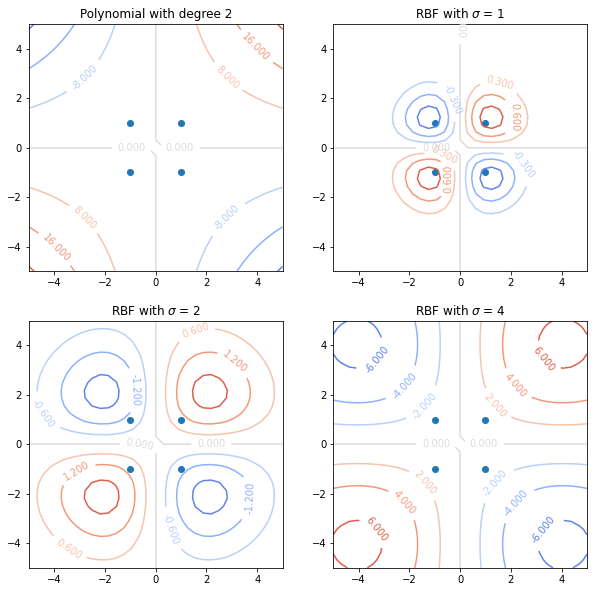

In [14]:
#def svm_contour(pred_fxn, xmin=-5, xmax=5, ymin=-5, ymax=5, ngrid = 33):
#    '''Plot the contour lines of the svm predictor. '''
figure(figsize=(10,10))

xmin,xmax,ymin,ymax = -5,5,-5,5
ngrid = 33
x,y = hw2_utils.xor_data()

subplot(2,2,1)
a = svm_solver(x, y, lr=0.1, num_iters=10000,
               kernel=hw2_utils.poly(degree=2), c=None)
with torch.no_grad():
    
    xgrid = torch.linspace(xmin, xmax, ngrid)
    ygrid = torch.linspace(ymin, ymax, ngrid)
    (xx, yy) = torch.meshgrid((xgrid, ygrid))
    x_test = torch.cat(
        (xx.view(ngrid, ngrid, 1), yy.view(ngrid, ngrid, 1)),
        dim = 2).view(-1, 2)

    zz = svm_predictor(a, x, y, x_test,
                  kernel=hw2_utils.poly(degree=2))
    zz = zz.view(ngrid, ngrid)
    cs = plt.contour(xx.cpu().numpy(), yy.cpu().numpy(), zz.cpu().numpy(),
                     cmap = 'coolwarm')
    plt.clabel(cs)
    plt.scatter(x[:,0],x[:,1])
    plt.title('Polynomial with degree 2')
    #plt.show()
    
subplot(2,2,2)
a = svm_solver(x, y, lr=0.1, num_iters=10000,
                   kernel=hw2_utils.rbf(sigma=1), c=None)
with torch.no_grad():
    
    xgrid = torch.linspace(xmin, xmax, ngrid)
    ygrid = torch.linspace(ymin, ymax, ngrid)
    (xx, yy) = torch.meshgrid((xgrid, ygrid))
    x_test = torch.cat(
        (xx.view(ngrid, ngrid, 1), yy.view(ngrid, ngrid, 1)),
        dim = 2).view(-1, 2)

    zz = svm_predictor(a, x, y, x_test,
                  kernel=hw2_utils.rbf(sigma=1))
    zz = zz.view(ngrid, ngrid)
    cs = plt.contour(xx.cpu().numpy(), yy.cpu().numpy(), zz.cpu().numpy(),
                     cmap = 'coolwarm')
    plt.clabel(cs)
    plt.scatter(x[:,0],x[:,1])
    plt.title('RBF with $\sigma$ = 1')
    #plt.show()

subplot(2,2,3)
a = svm_solver(x, y, lr=0.1, num_iters=10000,
                   kernel=hw2_utils.rbf(sigma=2), c=None)
with torch.no_grad():
    
    xgrid = torch.linspace(xmin, xmax, ngrid)
    ygrid = torch.linspace(ymin, ymax, ngrid)
    (xx, yy) = torch.meshgrid((xgrid, ygrid))
    x_test = torch.cat(
        (xx.view(ngrid, ngrid, 1), yy.view(ngrid, ngrid, 1)),
        dim = 2).view(-1, 2)

    zz = svm_predictor(a, x, y, x_test,
                  kernel=hw2_utils.rbf(sigma=2))
    zz = zz.view(ngrid, ngrid)
    cs = plt.contour(xx.cpu().numpy(), yy.cpu().numpy(), zz.cpu().numpy(),
                     cmap = 'coolwarm')
    plt.clabel(cs)
    plt.scatter(x[:,0],x[:,1])
    plt.title('RBF with $\sigma$ = 2')
    #plt.show()
    
subplot(2,2,4)
a = svm_solver(x, y, lr=0.1, num_iters=10000,
                   kernel=hw2_utils.rbf(sigma=4), c=None)
with torch.no_grad():
    
    xgrid = torch.linspace(xmin, xmax, ngrid)
    ygrid = torch.linspace(ymin, ymax, ngrid)
    (xx, yy) = torch.meshgrid((xgrid, ygrid))
    x_test = torch.cat(
        (xx.view(ngrid, ngrid, 1), yy.view(ngrid, ngrid, 1)),
        dim = 2).view(-1, 2)

    zz = svm_predictor(a, x, y, x_test,
                  kernel=hw2_utils.rbf(sigma=4))
    zz = zz.view(ngrid, ngrid)
    cs = plt.contour(xx.cpu().numpy(), yy.cpu().numpy(), zz.cpu().numpy(),
                     cmap = 'coolwarm')
    plt.clabel(cs)
    plt.scatter(x[:,0],x[:,1])
    plt.title('RBF with $\sigma$ = 4')
    plt.show()

In [15]:
class CAFENet(nn.Module):
    def __init__(self):
        '''
            Initialize the CAFENet by calling the superclass' constructor
            and initializing a linear layer to use in forward().

            Arguments:
                self: This object.
        '''
        super(CAFENet, self).__init__()
        self.fc = nn.Linear(380*240,6)

    def forward(self, x):
        '''
            Computes the network's forward pass on the input tensor.
            Does not apply a softmax or other activation functions.

            Arguments:
                self: This object.
                x: The tensor to compute the forward pass on.
        '''
        return self.fc(x)

In [16]:
def fit(net, X, y, n_epochs=5000):
    '''
    Trains the neural network with CrossEntropyLoss and an Adam optimizer on
    the training set X with training labels Y for n_epochs epochs.

    Arguments:
        net: The neural network to train
        X: n x d tensor
        y: n x 1 tensor
        n_epochs: The number of epochs to train with batch gradient descent.

    Returns:
        List of losses at every epoch, including before training
        (for use in plot_cafe_loss).
    '''
    out = []
    optimizer = optim.Adam(net.parameters())
    criterion = nn.CrossEntropyLoss()
    out += [criterion(net(X),y).item()]
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        net_out = net(X)
        loss = criterion(net_out,y)
        #out += [loss.item()]
        loss.backward()
        optimizer.step()
        out += [loss.item()]
    return out

In [17]:
my_nn = CAFENet()
#random_data = torch.rand((1, 1, 6,380*240,))

#my_nn = CAFENet()
#result = my_nn(random_data)

In [18]:
X,y = hw2_utils.get_cafe_data()

In [19]:
X.shape

torch.Size([54, 91200])

In [21]:
y

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5,
        5, 5, 5, 5, 5, 5])

In [22]:
y.shape

torch.Size([54])

In [24]:
loss = fit(my_nn,X,y,200)

Text(0, 0.5, 'loss')

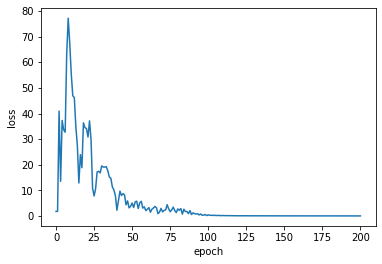

In [25]:
plot(loss)
xlabel('epoch')
ylabel('loss')

In [26]:
weights = my_nn.fc.weight

In [27]:
weights.shape

torch.Size([6, 91200])

In [346]:
for i in range(weights.shape[0]):
    min_weight = weights[i].min()
    max_weight = weights[i].max()
    weights[i] = (weights[i]-min_weight)*255./(max_weight-min_weight)

In [365]:
weights = torch.from_numpy(int32(weights.detach()))

In [367]:
weights = weights.reshape(6,380,-1)

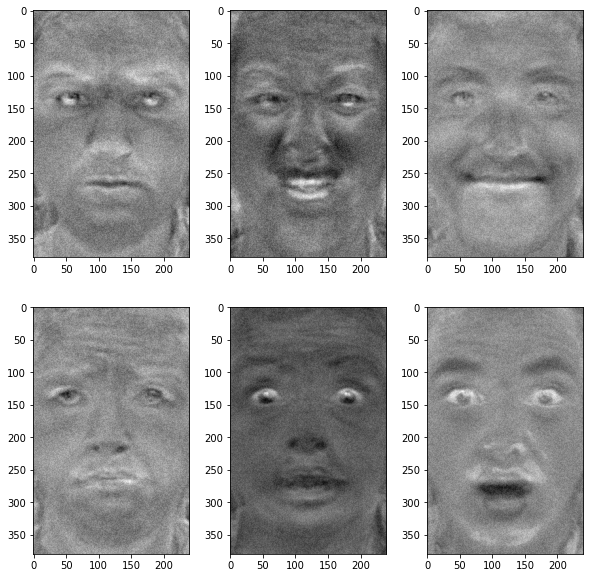

In [381]:
figure(figsize=(10,10))
subplot(2,3,1)
imshow(weights[0],cmap = 'gray')
subplot(2,3,2)
imshow(weights[1],cmap = 'gray')
subplot(2,3,3)
imshow(weights[2],cmap = 'gray')
subplot(2,3,4)
imshow(weights[3],cmap = 'gray')
subplot(2,3,5)
imshow(weights[4],cmap = 'gray')
subplot(2,3,6)
imshow(weights[5],cmap = 'gray')

In [6]:
class DigitsConvNet(nn.Module):
    def __init__(self):
        '''
        Initializes the layers of your neural network by calling the superclass
        constructor and setting up the layers.

        You should use nn.Conv2d, nn.MaxPool2D, and nn.Linear
        The layers of your neural network (in order) should be
        1) a 2D convolutional layer with 1 input channel and 8 outputs, with a kernel size of 3, followed by
        2) a 2D maximimum pooling layer, with kernel size 2
        3) a 2D convolutional layer with 8 input channels and 4 output channels, with a kernel size of 3
        4) a fully connected (Linear) layer with 4 inputs and 10 outputs
        '''
        super(DigitsConvNet,self).__init__()
        self.conv1 = nn.Conv2d(1,8,3)
        self.conv2 = nn.Conv2d(8,4,3)
        self.pool = nn.MaxPool2d(2)
        self.fc = nn.Linear(4,10)
        

    def forward(self, xb):
        '''
        A forward pass of your neural network.

        Note that the nonlinearity between each layer should be F.relu.  You
        may need to use a tensor's view() method to reshape outputs

        Arguments:
            self: This object.
            xb: An (N,8,8) torch tensor.

        Returns:
            An (N, 10) torch tensor
        '''
        xb = xb.view(xb.size()[0],1,xb.size()[1],-1) 
        xb = F.relu(self.conv1(xb))
        xb = F.max_pool2d(xb,2)
        xb = F.relu(self.conv2(xb))
        xb = xb.view(xb.size()[0],-1)
        xb = self.fc(xb)
        
        return xb
        
        

In [86]:
x = torch.randn(10,8,8)

In [ ]:
x.view(x.size()[0],1,)

In [62]:
def fit_and_evaluate(net, optimizer, loss_func, train, test, n_epochs, batch_size=1):
    '''
    Fits the neural network using the given optimizer, loss function, training set
    Arguments:
        net: the neural network
        optimizer: a optim.Optimizer used for some variant of stochastic gradient descent
        train: a torch.utils.data.Dataset
        test: a torch.utils.data.Dataset
        n_epochs: the number of epochs over which to do gradient descent
        batch_size: the number of samples to use in each batch of gradient descent

    Returns:
        train_epoch_loss, test_epoch_loss: two arrays of length n_epochs+1,
        containing the mean loss at the beginning of training and after each epoch
    '''
    train_dl = torch.utils.data.DataLoader(train, batch_size)
    test_dl = torch.utils.data.DataLoader(test)

    train_losses = []
    test_losses = []
    
    # Compute the loss on the training and validation sets at the start,
    # being sure not to store gradient information (e.g. with torch.no_grad():)

    # Train the network for n_epochs, storing the training and validation losses
    # after every epoch. Remember not to store gradient information while calling
    # epoch_loss
    with torch.no_grad():
        #train_losses.append(hw2_utils.epoch_loss(net, loss_func, train_dl))
        #test_losses.append(hw2_utils.epoch_loss(net, loss_func, test_dl))
        train_losses += [hw2_utils.epoch_loss(net, loss_func, train_dl)]
        test_losses += [hw2_utils.epoch_loss(net, loss_func, test_dl)]
    # Train the network for n_epochs, storing the training and validation losses
    # after every epoch. Remember not to store gradient information while calling
    # epoch_loss

    for i in range(n_epochs):
        for x, y in train_dl:
            hw2_utils.train_batch(net, loss_func, x, y, optimizer)
            
        with torch.no_grad():
            #train_losses.append(hw2_utils.epoch_loss(net, loss_func, train_dl))
            #test_losses.append(hw2_utils.epoch_loss(net, loss_func, test_dl))
            train_losses += [hw2_utils.epoch_loss(net, loss_func, train_dl)]
            test_losses += [hw2_utils.epoch_loss(net, loss_func, test_dl)]
    return train_losses, test_losses

In [63]:
def fit_and_evaluate_2(net, loss_func, train, test, n_epochs, batch_size=1):
    '''
    Fits the neural network using the given optimizer, loss function, training set
    Arguments:
        net: the neural network
        optimizer: a optim.Optimizer used for some variant of stochastic gradient descent
        train: a torch.utils.data.Dataset
        test: a torch.utils.data.Dataset
        n_epochs: the number of epochs over which to do gradient descent
        batch_size: the number of samples to use in each batch of gradient descent

    Returns:
        train_epoch_loss, test_epoch_loss: two arrays of length n_epochs+1,
        containing the mean loss at the beginning of training and after each epoch
    '''
    train_dl = torch.utils.data.DataLoader(train, batch_size)
    test_dl = torch.utils.data.DataLoader(test)

    train_losses = []
    test_losses = []

    # Compute the loss on the training and validation sets at the start,
    # being sure not to store gradient information (e.g. with torch.no_grad():)
    
    with torch.no_grad():
        train_losses.append(hw2_utils.epoch_loss(net, loss_func, train_dl))
        test_losses.append(hw2_utils.epoch_loss(net, loss_func, test_dl))

    # Train the network for n_epochs, storing the training and validation losses
    # after every epoch. Remember not to store gradient information while calling
    # epoch_loss
    
    optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0)

    for i in range(n_epochs):
        for xb, yb in train_dl:
            hw2_utils.train_batch(net, loss_func, xb, yb, optimizer)
            
        with torch.no_grad():
            train_losses.append(hw2_utils.epoch_loss(net, loss_func, train_dl))
            test_losses.append(hw2_utils.epoch_loss(net, loss_func, test_dl))
            
        optimizer = optim.SGD(net.parameters(), lr=0.005*(0.95**(i+1)), momentum=0)

    return train_losses, test_losses

In [8]:
train

In [7]:
net = DigitsConvNet()
train, test = hw2_utils.torch_digits()
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0)
loss_func = torch.nn.CrossEntropyLoss()
train_loss, test_loss = fit_and_evaluate(net, optimizer, loss_func, train, test, 30)

NameError: name 'fit_and_evaluate' is not defined

In [83]:
net = DigitsConvNet()
#train, test = hw2_utils.torch_digits()
#loss_func = torch.nn.CrossEntropyLoss()
train_loss2, test_loss2 = fit_and_evaluate_2(net, loss_func, train, test, 30)

In [84]:
net = DigitsConvNet()
#train, test = hw2_utils.torch_digits()
#loss_func = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0)
train_loss3, test_loss3 = fit_and_evaluate(net, optimizer, loss_func, train, test, 30, batch_size=16)

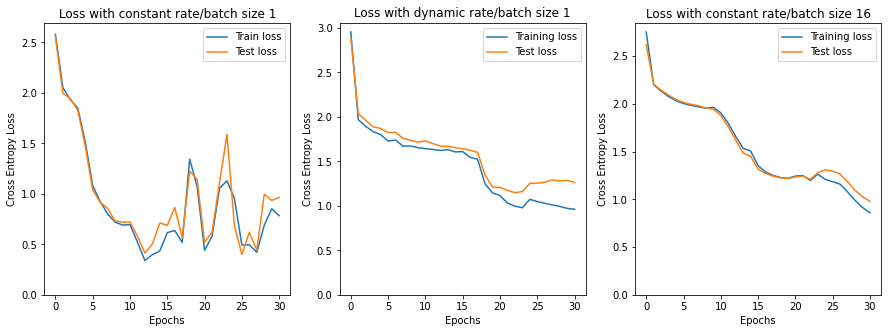

In [72]:
figure(figsize=(15,5))
subplot(1,3,1)
plot(train_loss,label='Train loss')
plot(test_loss,label='Test loss')
ylim(ymin=0)
title('Loss with constant rate/batch size 1')
xlabel('Epochs')
ylabel('Cross Entropy Loss')
legend()

subplot(1,3,2)
plot(train_loss2,label='Training loss')
plot(test_loss2,label='Test loss')
ylim(ymin=0)
title('Loss with dynamic rate/batch size 1')
xlabel('Epochs')
ylabel('Cross Entropy Loss')
legend()
subplot(1,3,3)
plot(train_loss3,label='Training loss')
plot(test_loss3,label='Test loss')
ylim(ymin=0)
title('Loss with constant rate/batch size 16')
xlabel('Epochs')
ylabel('Cross Entropy Loss')
legend()

Text(0, 0.5, 'cross-entropy losses')

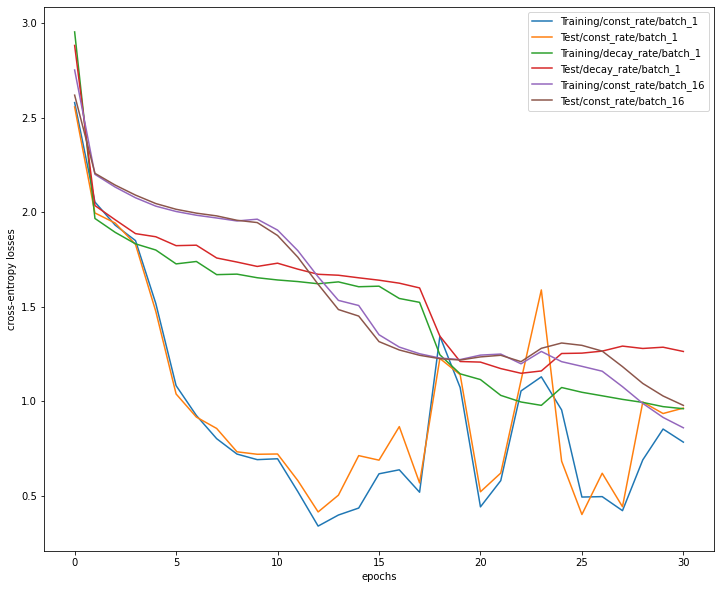

In [73]:
figure(figsize=(12,10))
plot(train_loss,label='Training/const_rate/batch_1')
plot(test_loss,label='Test/const_rate/batch_1')
plot(train_loss2,label='Training/decay_rate/batch_1')
plot(test_loss2,label='Test/decay_rate/batch_1')
plot(train_loss3,label='Training/const_rate/batch_16')
plot(test_loss3,label='Test/const_rate/batch_16')
legend()
xlabel('epochs')
ylabel('cross-entropy losses')

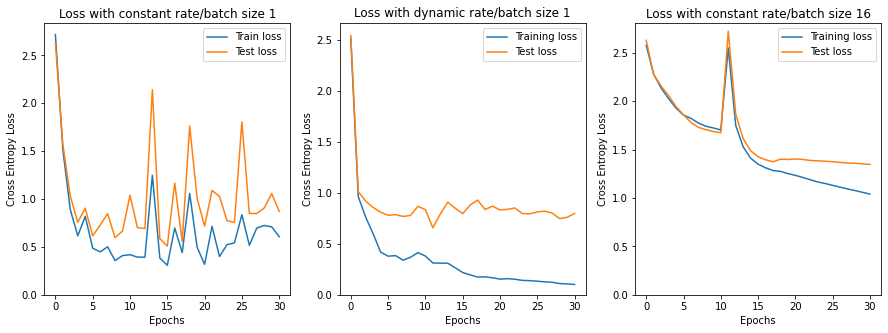

In [81]:
figure(figsize=(15,5))
subplot(1,3,1)
plot(train_loss,label='Train loss')
plot(test_loss,label='Test loss')
ylim(ymin=0)
title('Loss with constant rate/batch size 1')
xlabel('Epochs')
ylabel('Cross Entropy Loss')
legend()

subplot(1,3,2)
plot(train_loss2,label='Training loss')
plot(test_loss2,label='Test loss')
ylim(ymin=0)
title('Loss with dynamic rate/batch size 1')
xlabel('Epochs')
ylabel('Cross Entropy Loss')
legend()
subplot(1,3,3)
plot(train_loss3,label='Training loss')
plot(test_loss3,label='Test loss')
ylim(ymin=0)
title('Loss with constant rate/batch size 16')
xlabel('Epochs')
ylabel('Cross Entropy Loss')
legend()

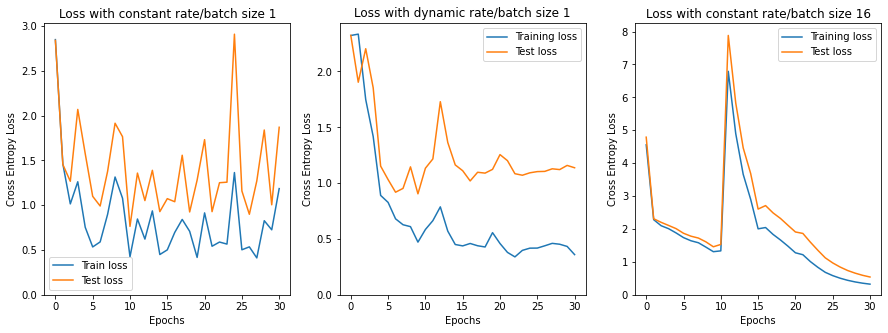

In [85]:
figure(figsize=(15,5))
subplot(1,3,1)
plot(train_loss,label='Train loss')
plot(test_loss,label='Test loss')
ylim(ymin=0)
title('Loss with constant rate/batch size 1')
xlabel('Epochs')
ylabel('Cross Entropy Loss')
legend()

subplot(1,3,2)
plot(train_loss2,label='Training loss')
plot(test_loss2,label='Test loss')
ylim(ymin=0)
title('Loss with dynamic rate/batch size 1')
xlabel('Epochs')
ylabel('Cross Entropy Loss')
legend()
subplot(1,3,3)
plot(train_loss3,label='Training loss')
plot(test_loss3,label='Test loss')
ylim(ymin=0)
title('Loss with constant rate/batch size 16')
xlabel('Epochs')
ylabel('Cross Entropy Loss')
legend()